# Plot a histogram of arm choices for each stationary period.


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle
import math

from src import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
1,1,1,1,1,3
4,1,1,1,1,3
5,1,1,1,1,1
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12950,4,4,3,1,1
12951,4,4,3,2,2
12953,4,4,3,2,1
12954,4,4,3,2,2


In [6]:
all_rewards

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3405, 0.3372, 0.3223])

In [13]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [14]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.023
Min expected reward for arm 3: 0.0


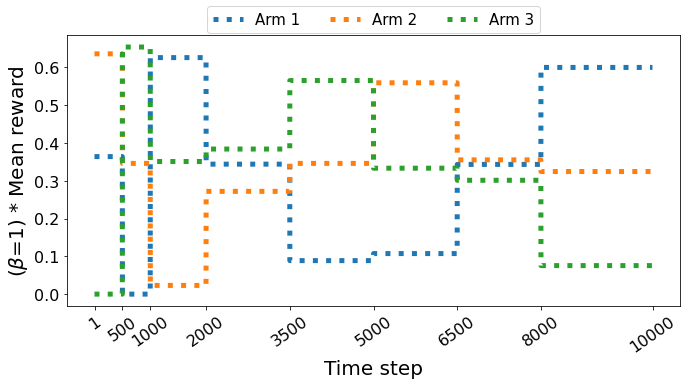

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [16]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [17]:
cost_means_range = [0.01, 0.05]

In [18]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [19]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [20]:
interval_means

[array([0.0249816 , 0.04802857, 0.03927976, 0.03394634, 0.01624075]),
 array([0.01623978, 0.01232334, 0.04464705, 0.0340446 , 0.0383229 ]),
 array([0.01082338, 0.04879639, 0.04329771, 0.01849356, 0.017273  ]),
 array([0.01733618, 0.02216969, 0.03099026, 0.0272778 , 0.02164917]),
 array([0.03447412, 0.01557975, 0.02168579, 0.02465447, 0.0282428 ])]

In [21]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [22]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

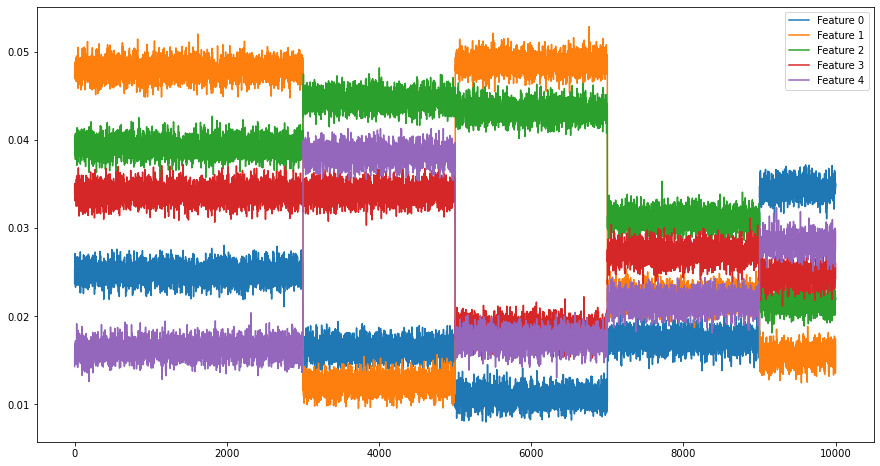

In [23]:
plot_costs(get_costs(), new_contexts.shape[0])

In [24]:
costs_obj = get_costs()

In [25]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [26]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [27]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [28]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

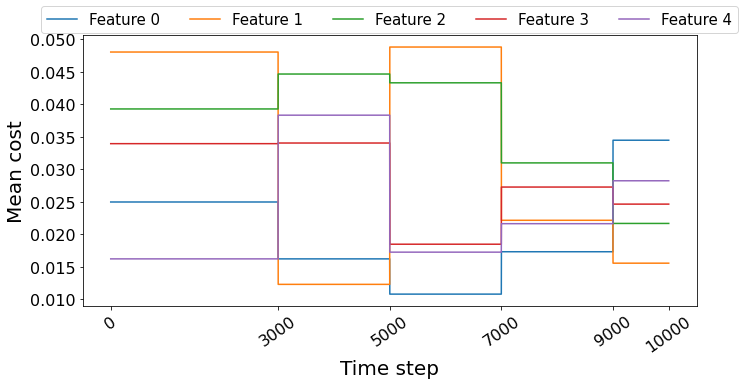

In [29]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [30]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.1700929951305659
Min expected gain for arm 2: -0.14641175322662411
Min expected gain for arm 3: -0.16805707788587704


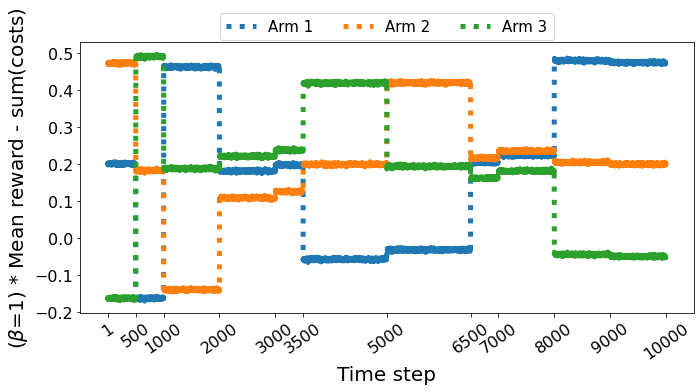

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [32]:
def plot_gains(gain_dict, reward_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4)
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Created change points

In [33]:
# Reward changes
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [34]:
# Cost changes
cost_change_points

[3000, 5000, 7000, 9000]

In [35]:
all_change_point_values

[1, 500, 1000, 2000, 3000, 3500, 5000, 6500, 7000, 8000, 9000, 10000]

In [36]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

In [37]:
all_stationarity_regions

[(1, 500),
 (500, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 3500),
 (3500, 5000),
 (5000, 6500),
 (6500, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

### Function to get histogram from list of chosen arms

In [38]:
def get_histograms(arms_list, regions):
    arms = np.array(arms_list)
    n_arms = len(np.unique(arms))
    n_regions = len(regions)
    histograms = np.zeros((n_regions, n_arms))
    for i, region in enumerate(regions):
        arms_in_region = arms[slice(*region)]
        region_histogram = np.zeros(n_arms)
        for arm in range(n_arms):
            region_histogram[arm] = np.count_nonzero(arms_in_region == arm)
        histograms[i, :] = region_histogram
        
    return histograms

# Running evaluation

In [39]:
# Histogram dict for every algorithm. Averaged histograms are saved
histograms = {}

In [40]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5
N_ARMS = all_rewards.shape[1]

In [41]:
np.random.seed(42)

In [42]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random, _, _, arms_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_random[i, :] = gain_random
    hists[i, :, :] = get_histograms(arms_random, all_stationarity_regions)
    
histograms['Random'] = np.mean(hists, axis=0)
gain_random = np.mean(gains_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3332.0
	Total reward: 3332.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3446.0
	Total reward: 3446.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3271.0
	Total reward: 3271.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3251.0
	Total reward: 3251.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3353.0
	Total reward: 3353.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3330.6


In [43]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy, _, _, arms_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_egreedy[i, :] = gain_egreedy
    hists[i, :, :] = get_histograms(arms_egreedy, all_stationarity_regions)
    
histograms['E-greedy'] = np.mean(hists, axis=0)
gain_egreedy = np.mean(gains_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3732.0
	Total reward: 3732.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3917.0
	Total reward: 3917.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3731.0
	Total reward: 3731.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3815.0
	Total reward: 3815.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3714.0
	Total reward: 3714.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3781.8


In [44]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb, _, _, arms_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_ucb[i, :] = gain_ucb
    hists[i, :, :] = get_histograms(arms_ucb, all_stationarity_regions)

histograms['UCB1'] = np.mean(hists, axis=0)
gain_ucb = np.mean(gains_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5270.0
	Total reward: 5270.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5270.0
	Total reward: 5270.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5270.0
	Total reward: 5270.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5270.0
	Total reward: 5270.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5270.0
	Total reward: 5270.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5270.0


In [45]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb, _, _, arms_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_linucb[i, :] = gain_linucb
    hists[i, :, :] = get_histograms(arms_linucb, all_stationarity_regions)
    
histograms['LinUCB'] = np.mean(hists, axis=0)
gain_linucb = np.mean(gains_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2829.551070859981
	Total reward: 4249.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2829.551070859981
	Total reward: 4249.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2829.551070859981
	Total reward: 4249.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2829.551070859981
	Total reward: 4249.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2829.551070859981
	Total reward: 4249.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
Average gain: 2829.551070859981


In [46]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb, _, _, arms_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_pslinucb[i, :] = gain_pslinucb
    hists[i, :, :] = get_histograms(arms_pslinucb, all_stationarity_regions)
    
histograms['PSLinUCB'] = np.mean(hists, axis=0)
gain_pslinucb = np.mean(gains_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5769.551070859987
	Total reward: 7189.0
	Total cost: 1419.4489291400032
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5769.551070859987
	Total reward: 7189.0
	Total cost: 1419.4489291400032
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5769.551070859987
	Total reward: 7189.0
	Total cost: 1419.4489291400032
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5769.551070859987
	Total reward: 7189.0
	Total cost: 1419.4489291400032
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5769.551070859987
	Total reward: 7189.0
	Total cost: 1419.4489291400032
Execution time: 0.4s
Average gain: 5769.551070859987


In [47]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, _, _, arms_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    hists[i, :, :] = get_histograms(arms_simoos, all_stationarity_regions)
    
histograms['SimOOS'] = np.mean(hists, axis=0)
gain_simoos = np.mean(gains_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0014488697052001953 seconds
Trial 0, time 2022-05-25 22:29:38.935069
Trial 500, time 2022-05-25 22:30:04.330540
Trial 1000, time 2022-05-25 22:30:17.713780
Trial 1500, time 2022-05-25 22:30:39.989536
Trial 2000, time 2022-05-25 22:31:03.123779
Trial 2500, time 2022-05-25 22:31:07.099636
Trial 3000, time 2022-05-25 22:31:08.503399
Trial 3500, time 2022-05-25 22:31:10.022846
Trial 4000, time 2022-05-25 22:31:10.861217
Trial 4500, time 2022-05-25 22:31:11.159153
Trial 5000, time 2022-05-25 22:31:13.201708
Trial 5500, time 2022-05-25 22:31:23.549517
Trial 6000, time 2022-05-25 22:31:24.833458
Trial 6500, time 2022-05-25 22:31:26.735396
Trial 7000, time 2022-05-25 22:31:27.815221
Trial 7500, time 2022-05-25 22:31:32.655411
Trial 8000, time 2022-05-25 22:31:43.861620
Trial 8500, time 2022-05-25 22:31:53.423675
Trial 9000, time 2022-05-25 22:32:02.879711
Trial 9500, time 2022-05-25 22:32:04.737088
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 2972.9226960062765
	Total reward: 3918.0


In [48]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, _, _, arms_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        hists[i, :, :] = get_histograms(arms_alg1, all_stationarity_regions)
    
histograms['Algorithm1'] = np.mean(hists, axis=0)
gain_alg1 = np.mean(gains_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.002050161361694336 seconds
Round 0, time 2022-05-25 22:42:08.137593
Round 500, time 2022-05-25 22:43:15.850553
Round 1000, time 2022-05-25 22:44:29.373872
Round 1500, time 2022-05-25 22:45:41.981216
Round 2000, time 2022-05-25 22:46:54.873870
Round 2500, time 2022-05-25 22:48:07.996287
Round 3000, time 2022-05-25 22:49:21.332653
Round 3500, time 2022-05-25 22:50:34.209258
Round 4000, time 2022-05-25 22:51:46.988280
Round 4500, time 2022-05-25 22:53:00.888999
Round 5000, time 2022-05-25 22:54:13.813258
Round 5500, time 2022-05-25 22:55:27.065840
Round 6000, time 2022-05-25 22:56:39.776632
Round 6500, time 2022-05-25 22:57:52.653260
Round 7000, time 2022-05-25 22:59:05.605217
Round 7500, time 2022-05-25 23:00:18.962547
Round 8000, time 2022-05-25 23:01:36.926075
Round 8500, time 2022-05-25 23:02:51.286405
Round 9000, time 2022-05-25 23:04:05.560864
Round 9500, time 2022-05-25 23:05:19.591094
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 7433.762150303802
	Total rewar

## Oracle

In [49]:
cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [50]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
hists = np.zeros((NUM_REPETITIONS, N_STATIONARY_PERIODS, N_ARMS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, _, _, arms_alg1_oracle = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        hists[i, :, :] = get_histograms(arms_alg1_oracle, all_stationarity_regions)

histograms['Oracle'] = np.mean(hists, axis=0)
gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.6195907592773438 seconds
Trial 0, time 2022-05-26 00:44:30.039076
Trial 500, time 2022-05-26 00:44:30.044766
Trial 1000, time 2022-05-26 00:44:30.050514
Trial 1500, time 2022-05-26 00:44:30.056733
Trial 2000, time 2022-05-26 00:44:30.062918
Trial 2500, time 2022-05-26 00:44:30.068496
Trial 3000, time 2022-05-26 00:44:30.074062
Trial 3500, time 2022-05-26 00:44:30.079651
Trial 4000, time 2022-05-26 00:44:30.087276
Trial 4500, time 2022-05-26 00:44:30.093786
Trial 5000, time 2022-05-26 00:44:30.100347
Trial 5500, time 2022-05-26 00:44:30.105994
Trial 6000, time 2022-05-26 00:44:30.111573
Trial 6500, time 2022-05-26 00:44:30.117267
Trial 7000, time 2022-05-26 00:44:30.123103
Trial 7500, time 2022-05-26 00:44:30.129764
Trial 8000, time 2022-05-26 00:44:30.136318
Trial 8500, time 2022-05-26 00:44:30.142948
Trial 9000, time 2022-05-26 00:44:30.149548
Trial 9500, time 2022-05-26 00:44:30.156255
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7609.932315667515
	Total reward: 8526.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.6121900081634521 seconds
Trial 0, time 2022-05-26 00:44:30.776132
Trial 500, time 2022-05-26 00:44:30.781651
Trial 1000, time 2022-05-26 00:44:30.787303
Trial 1500, time 2022-05-26 00:44:30.793509
Trial 2000, time 2022-05-26 00:44:30.799656
Trial 2500, time 2022-05-26 00:44:30.805168
Trial 3000, time 2022-05-26 00:44:30.810728
Trial 3500, time 2022-05-26 00:44:30.816368
Trial 4000, time 2022-05-26 00:44:30.822992
Trial 4500, time 2022-05-26 00:44:30.829693
Trial 5000, time 2022-05-26 00:44:30.836228
Trial 5500, time 2022-05-26 00:44:30.841827
Trial 6000, time 2022-05-26 00:44:30.847519
Trial 6500, time 2022-05-26 00:44:30.853091
Trial 7000, time 2022-05-26 00:44:30.858967
Trial 7500, time 2022-05-26 00:44:30.865588
Trial 8000, time 2022-05-26 00:44:30.872155
Trial 8500, time 2022-05-26 00:44:30.878797
Trial 9000, time 2022-05-26 00:44:30.885511
Trial 9500, time 2022-05-26 00:44:30.892190
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7609.932315667515
	Total reward: 8526.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.6116361618041992 seconds
Trial 0, time 2022-05-26 00:44:31.511607
Trial 500, time 2022-05-26 00:44:31.517257
Trial 1000, time 2022-05-26 00:44:31.522826
Trial 1500, time 2022-05-26 00:44:31.529115
Trial 2000, time 2022-05-26 00:44:31.535272
Trial 2500, time 2022-05-26 00:44:31.540816
Trial 3000, time 2022-05-26 00:44:31.546395
Trial 3500, time 2022-05-26 00:44:31.552147
Trial 4000, time 2022-05-26 00:44:31.558907
Trial 4500, time 2022-05-26 00:44:31.565532
Trial 5000, time 2022-05-26 00:44:31.572854
Trial 5500, time 2022-05-26 00:44:31.578435
Trial 6000, time 2022-05-26 00:44:31.584082
Trial 6500, time 2022-05-26 00:44:31.589716
Trial 7000, time 2022-05-26 00:44:31.595586
Trial 7500, time 2022-05-26 00:44:31.602295
Trial 8000, time 2022-05-26 00:44:31.608910
Trial 8500, time 2022-05-26 00:44:31.615594
Trial 9000, time 2022-05-26 00:44:31.622232
Trial 9500, time 2022-05-26 00:44:31.628929
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7609.932315667515
	Total reward: 8526.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.6123497486114502 seconds
Trial 0, time 2022-05-26 00:44:32.249134
Trial 500, time 2022-05-26 00:44:32.254777
Trial 1000, time 2022-05-26 00:44:32.260287
Trial 1500, time 2022-05-26 00:44:32.266386
Trial 2000, time 2022-05-26 00:44:32.272576
Trial 2500, time 2022-05-26 00:44:32.278149
Trial 3000, time 2022-05-26 00:44:32.283665
Trial 3500, time 2022-05-26 00:44:32.289343
Trial 4000, time 2022-05-26 00:44:32.295935
Trial 4500, time 2022-05-26 00:44:32.302454
Trial 5000, time 2022-05-26 00:44:32.308975
Trial 5500, time 2022-05-26 00:44:32.314559
Trial 6000, time 2022-05-26 00:44:32.320236
Trial 6500, time 2022-05-26 00:44:32.325897
Trial 7000, time 2022-05-26 00:44:32.331774
Trial 7500, time 2022-05-26 00:44:32.338363
Trial 8000, time 2022-05-26 00:44:32.344926
Trial 8500, time 2022-05-26 00:44:32.351556
Trial 9000, time 2022-05-26 00:44:32.358181
Trial 9500, time 2022-05-26 00:44:32.364871
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7609.932315667515
	Total reward: 8526.0
	Tot

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Took 0.6117050647735596 seconds
Trial 0, time 2022-05-26 00:44:32.984400
Trial 500, time 2022-05-26 00:44:32.990162
Trial 1000, time 2022-05-26 00:44:32.995730
Trial 1500, time 2022-05-26 00:44:33.001866
Trial 2000, time 2022-05-26 00:44:33.008000
Trial 2500, time 2022-05-26 00:44:33.013535
Trial 3000, time 2022-05-26 00:44:33.019053
Trial 3500, time 2022-05-26 00:44:33.024713
Trial 4000, time 2022-05-26 00:44:33.031267
Trial 4500, time 2022-05-26 00:44:33.037697
Trial 5000, time 2022-05-26 00:44:33.044248
Trial 5500, time 2022-05-26 00:44:33.049933
Trial 6000, time 2022-05-26 00:44:33.055545
Trial 6500, time 2022-05-26 00:44:33.061138
Trial 7000, time 2022-05-26 00:44:33.067067
Trial 7500, time 2022-05-26 00:44:33.073815
Trial 8000, time 2022-05-26 00:44:33.080463
Trial 8500, time 2022-05-26 00:44:33.087109
Trial 9000, time 2022-05-26 00:44:33.093782
Trial 9500, time 2022-05-26 00:44:33.100537
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7609.932315667515
	Total reward: 8526.0
	Tot

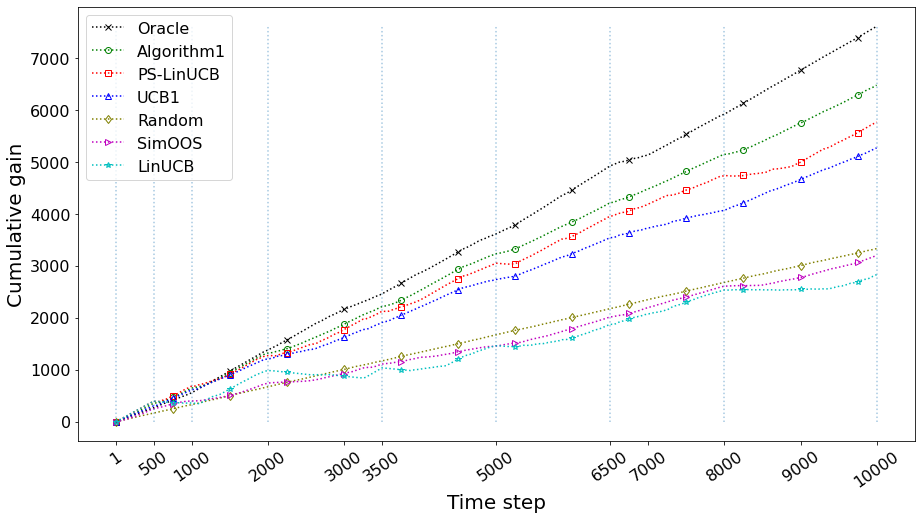

In [51]:
plot_gains(
    {
    'Random': gain_random,
#     'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
    'Oracle': gain_alg1_oracle,
    },
    reward_change_points=change_point_values,
)


## Plot the histograms for each algorithm

In [52]:
histograms

{'Random': array([[164.8, 170.4, 163.8],
        [172.6, 168. , 159.4],
        [344.6, 324.8, 330.6],
        [349. , 328.4, 322.6],
        [175.8, 162.2, 162. ],
        [506.4, 496.2, 497.4],
        [475.2, 518.2, 506.6],
        [163.8, 164. , 172.2],
        [344.8, 331. , 324.2],
        [320.4, 335.8, 343.8],
        [324.4, 337. , 338.6]]),
 'E-greedy': array([[ 154. ,  339.6,    5.4],
        [  31.6,  410.8,   57.6],
        [ 446.8,  308. ,  245.2],
        [ 788.4,   78. ,  133.6],
        [ 392.6,    4.2,  103.2],
        [ 355.6,   14.2, 1130.2],
        [  13.2,   15.2, 1471.6],
        [   5.4,    3.8,  490.8],
        [  11.8,    7. ,  981.2],
        [ 422. ,   54.6,  523.4],
        [ 901.8,   32.8,   65.4]]),
 'UCB1': array([[6.000e+00, 4.860e+02, 7.000e+00],
        [1.000e+00, 3.800e+01, 4.610e+02],
        [9.260e+02, 9.000e+00, 6.500e+01],
        [2.040e+02, 2.320e+02, 5.640e+02],
        [5.000e+00, 2.100e+02, 2.850e+02],
        [2.900e+01, 1.090e+02, 1.362

In [53]:
all_stationarity_regions

[(1, 500),
 (500, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 3500),
 (3500, 5000),
 (5000, 6500),
 (6500, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

## Saving and loading data

In [54]:
data_to_save = {
    'histograms': histograms,
    'all_stationarity_regions': all_stationarity_regions,
}

In [55]:
with open('experiments/nursery/results/histograms.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)

In [56]:
with open('experiments/nursery/results/histograms.pickle', 'rb') as f:
    data_to_save = pickle.load(f)

In [57]:
histograms = data_to_save['histograms']
all_stationarity_regions = data_to_save['all_stationarity_regions']

In [58]:
algs_to_plot = ["Oracle", "Algorithm1", "PSLinUCB"]
colors = ['cyan', 'red', 'blue']

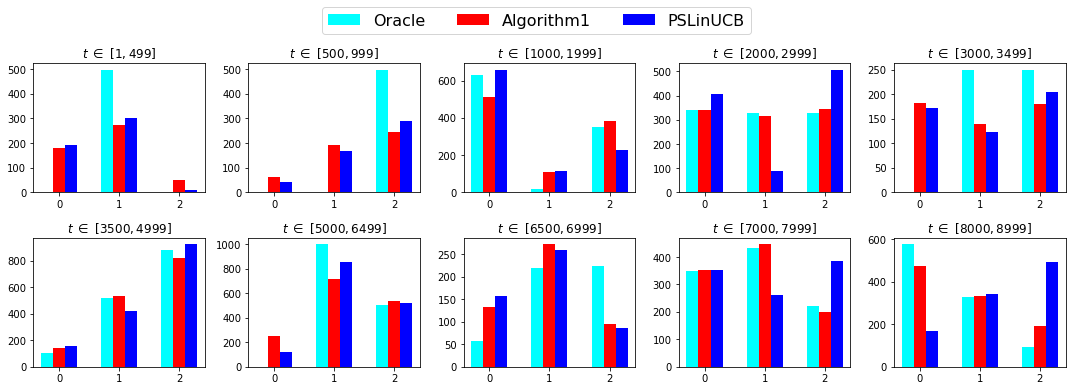

In [59]:
fig, axs = plt.subplots(2, math.floor(N_STATIONARY_PERIODS/2), figsize=(15, 5))

x = np.array([0, 1, 2])

handles = []
for period_num, ax in enumerate(axs.flatten()):
    if period_num >= N_STATIONARY_PERIODS:
        break
    for alg_num, alg_name in enumerate(algs_to_plot):
        
        bar = ax.bar(-0.2 + x+alg_num*0.2,
               histograms[alg_name][period_num, :],
               width=0.2,
               color=colors[alg_num],
               label=alg_name,
        )
        period = all_stationarity_regions[period_num]
        ax.set_title(fr"$t\ \in \ [{period[0]}, {period[1]-1}]$")
        if period_num == 0:
            handles.append(bar)
            
        


fig.legend(handles, algs_to_plot, loc="upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3, prop={'size': 16})
plt.tight_layout()
plt.show()